In [15]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [16]:
#%matplotlib notebook

In [17]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn import decomposition
from sklearn.cluster import (KMeans, AgglomerativeClustering)

SEED = 666

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

sns.set_style('white')

from audiovocana.conf import (FFTFREQS, MELFREQS)
from audiovocana.dataset import get_dataset

PLOT = True
VOCALIZATION = 1
RESULTS_FOLDER = "/home/utilisateur/Desktop/palomars/usv-experiments/dev-dataset-20200410/results/audibles"

In [18]:
csv_path = '/home/utilisateur/Desktop/palomars/data/dev/dataset.csv'
cache_folder = '/home/utilisateur/Desktop/palomars/cache/dev_dataset'
xlsx_folder = "/home/utilisateur/Desktop/palomars/data/dev"
audio_folder = "/home/utilisateur/Desktop/palomars/data/dev"

In [19]:
dataset = get_dataset(
    csv_path=csv_path,
    cache_folder=cache_folder,
    shuffle=False,
    recompute=False
)

Reading csv from /home/utilisateur/Desktop/palomars/data/dev/dataset.csv.
Found 377 events from 3 different experiments and 9 different recordings


In [20]:
dataset = dataset.filter(lambda sample: sample['vocalization'] == VOCALIZATION)

In [21]:
vocs = np.array([sample['vocalization'] for sample in iter(dataset)])
postnataldays = np.array([sample['postnatalday'].numpy() for sample in iter(dataset)])
nests = np.array([sample['nest'].numpy() for sample in iter(dataset)])
recordings = np.array([sample['recording'].numpy() for sample in iter(dataset)])

dicc_vocs = {
    1: 'tab:blue',
    2: 'tab:orange'
}
colors_vocs = pd.DataFrame(vocs)[0].map(dicc_vocs)

dicc_recordings = {
    482: 'y',
    494: 'g',
    637: 'r'
} 
colors_recordings = pd.DataFrame(recordings)[0].map(dicc_recordings)

dicc_nests = {
    1: 'c',
    2: 'm'
}
colors_nest = pd.DataFrame(nests)[0].map(dicc_nests)

dicc_pnds = dict(zip(set(postnataldays),sns.color_palette("Blues", len(set(postnataldays)))))
colors_pnds = pd.DataFrame(postnataldays)[0].map(dicc_pnds)

colors = pd.concat([colors_vocs, colors_recordings, colors_nest, colors_pnds], axis=1)
colors.columns = ['vocalization', 'recording', 'nest', 'postnatalday']

In [22]:
print(f"Nb audibles = {np.sum(vocs == 1)}")
print(f"Nb USVs = {np.sum(vocs == 2)}")
print(f"Audible events represents the {100 * np.sum(vocs == 1)/len(vocs)}% of total.")

Nb audibles = 46
Nb USVs = 0
Audible events represents the 100.0% of total.


Text(0.5, 1.0, 'VOCALIZATION TYPE')

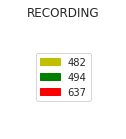

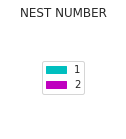

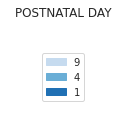

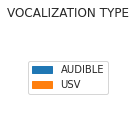

In [23]:
def plot_legend(colordicc, title):
    legend_elements = [Patch(facecolor=c, edgecolor=c, label=l) for l, c in colordicc.items()]
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.legend(handles=legend_elements, loc='center')
    plt.title(title)
    plt.axis('off')

plot_legend(dicc_recordings, 'RECORDING')
plot_legend(dicc_nests, 'NEST NUMBER')
plot_legend(dicc_pnds, 'POSTNATAL DAY')


legend_elements = [
    Patch(facecolor='tab:blue', edgecolor='tab:blue', label='AUDIBLE'),
    Patch(facecolor='tab:orange', edgecolor='tab:orange', label='USV')
]
fig, ax = plt.subplots(figsize=(2, 2))
ax.legend(handles=legend_elements, loc='center')
plt.axis('off')
plt.title('VOCALIZATION TYPE')

In [24]:
feats = dict()
for feat in  ['max_mfcc', 'mean_mfcc', 'mean_stft', 'max_stft', 'mean_mel', 'max_mel']: 
    feats[feat] = np.array([sample[feat] for sample in tqdm(iter(dataset))])

46it [00:00, 728.08it/s]
46it [00:00, 657.13it/s]
46it [00:00, 695.61it/s]
46it [00:00, 796.93it/s]
46it [00:00, 657.62it/s]
46it [00:00, 682.50it/s]


In [25]:
xlabels =  np.array([
    str(sample['recording'].numpy())+'_'+str(sample['event'].numpy())
    for sample in iter(dataset)
])

dicc_xlabels = dict(zip(set([x[:3] for x in  xlabels]),  sns.xkcd_palette( ["amber", "greyish", "dusty purple"]) ))

In [26]:
def get_ylabels(name, num):
    if name == 'stft':
        return np.linspace(FFTFREQS[0], FFTFREQS[-1], num=num, dtype=np.int)
    elif name == '_mel':
        return np.linspace(MELFREQS[0], MELFREQS[-1], num=num, dtype=np.int)
    elif name == 'mfcc':
        return np.linspace(0, num, num=num, dtype=np.int)


In [27]:
def hcluster(X, method, metric, colors, feat):
    
    g = sns.clustermap(
        pd.DataFrame(X),
        method=method,
        metric=metric,
        standard_scale=None, # Max-0 scaling. Either 0 (rows) or 1 (columns) or None
        z_score=0, # Whitening. Either 0 (by rows) or 1 (by columns) or None
        row_cluster=False,
        col_colors=colors,
        center=None, # check what this is, looks different with 0
        figsize=(16, 8),
        cbar_pos=None,
        xticklabels=1,
        yticklabels='auto')
       
    for tick in g.ax_heatmap.axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(8) 
        tick.label.set_rotation('vertical')
        
             
    for tick in g.ax_heatmap.axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(2) 
        tick.label.set_rotation('horizontal')

    g.ax_heatmap.axes.set_yticklabels(
        get_ylabels(
            name=feat[-4:],
            num=len(g.ax_heatmap.axes.yaxis.get_major_ticks())
        )
    )
    
    return g

mean_stft-average-euclidean-clustermap-DEV-1
mean_stft-average-cosine-clustermap-DEV-1
mean_stft-average-sqeuclidean-clustermap-DEV-1
mean_stft-average-cityblock-clustermap-DEV-1
mean_stft-complete-euclidean-clustermap-DEV-1
mean_stft-complete-cosine-clustermap-DEV-1
mean_stft-complete-sqeuclidean-clustermap-DEV-1
mean_stft-complete-cityblock-clustermap-DEV-1
mean_stft-single-euclidean-clustermap-DEV-1
mean_stft-single-cosine-clustermap-DEV-1
mean_stft-single-sqeuclidean-clustermap-DEV-1
mean_stft-single-cityblock-clustermap-DEV-1


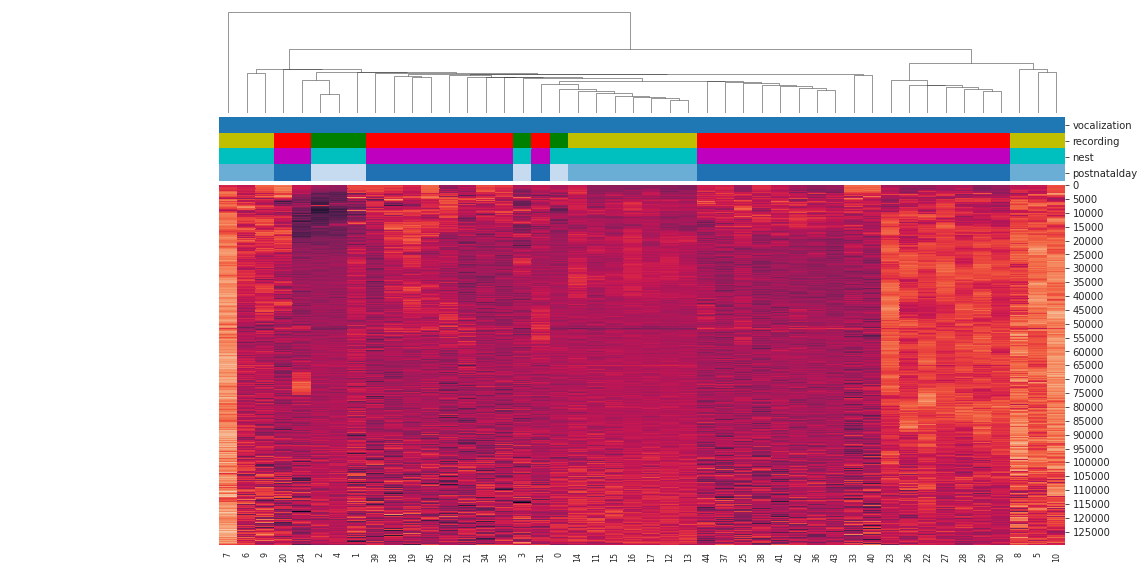

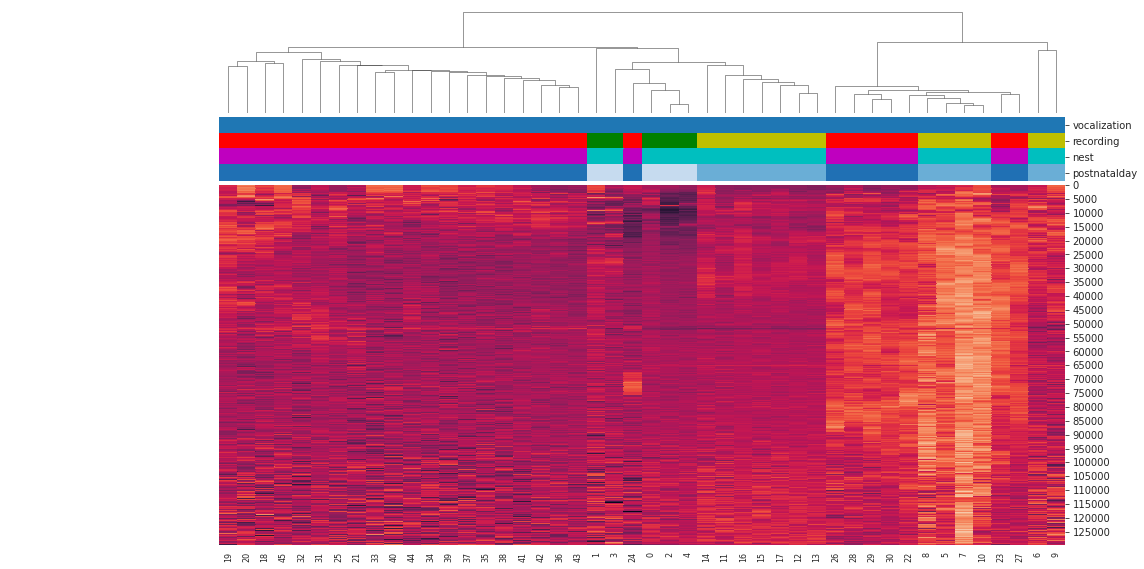

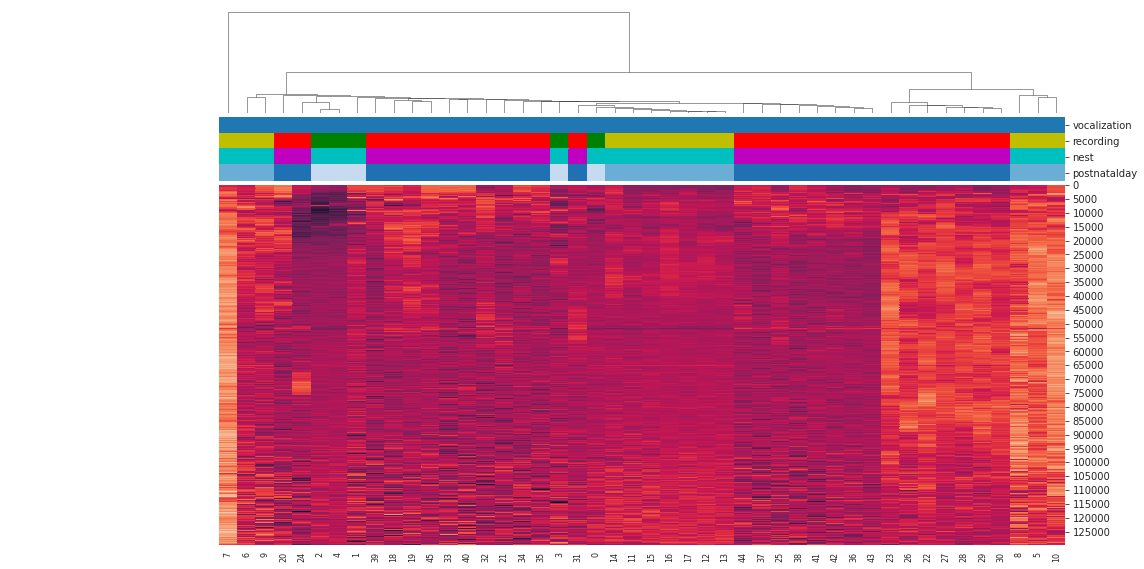

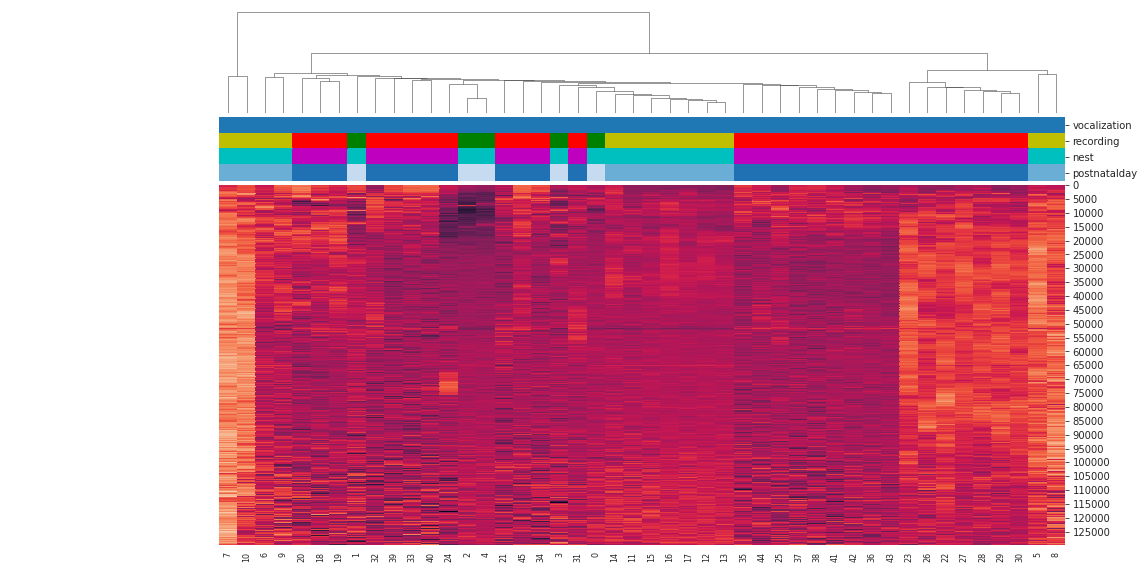

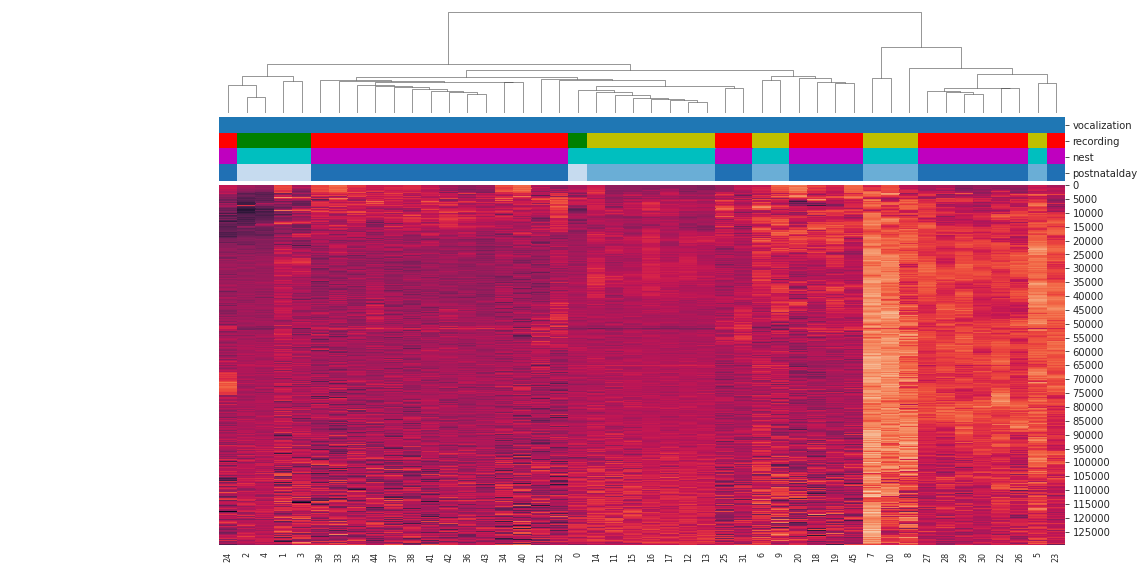

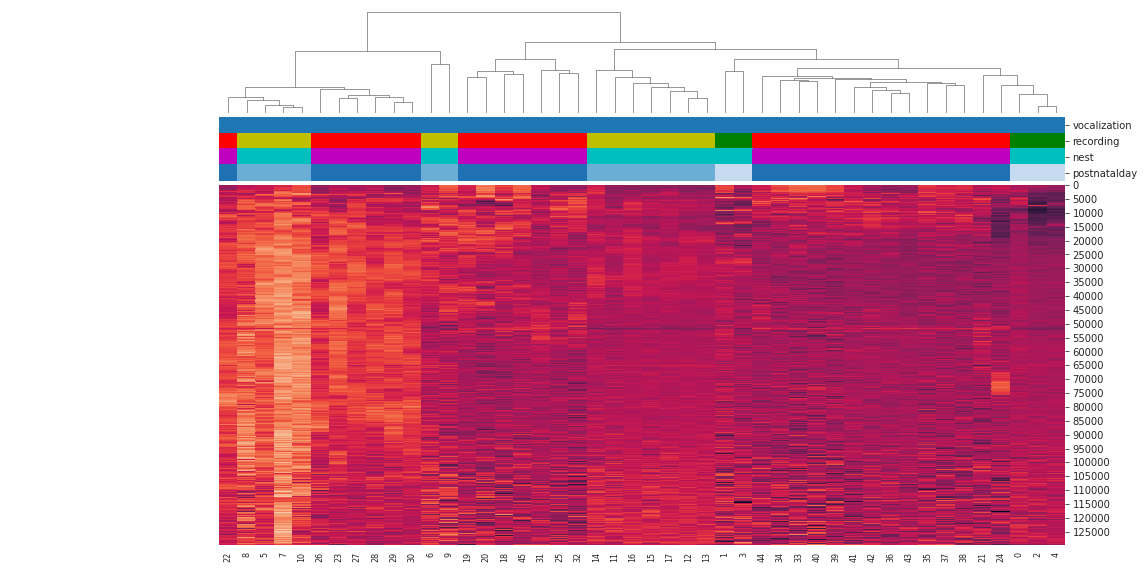

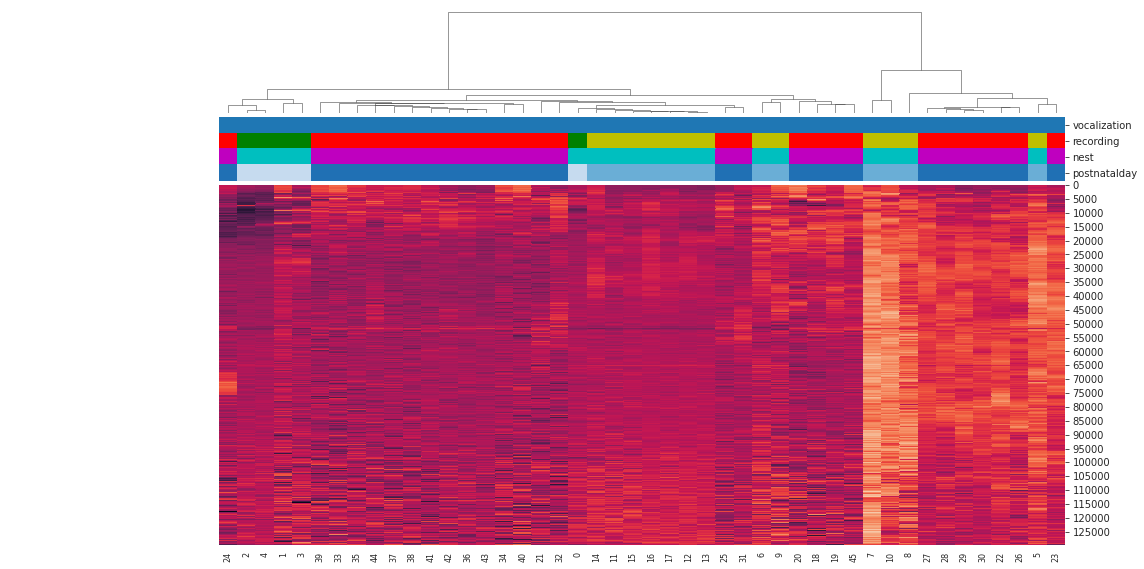

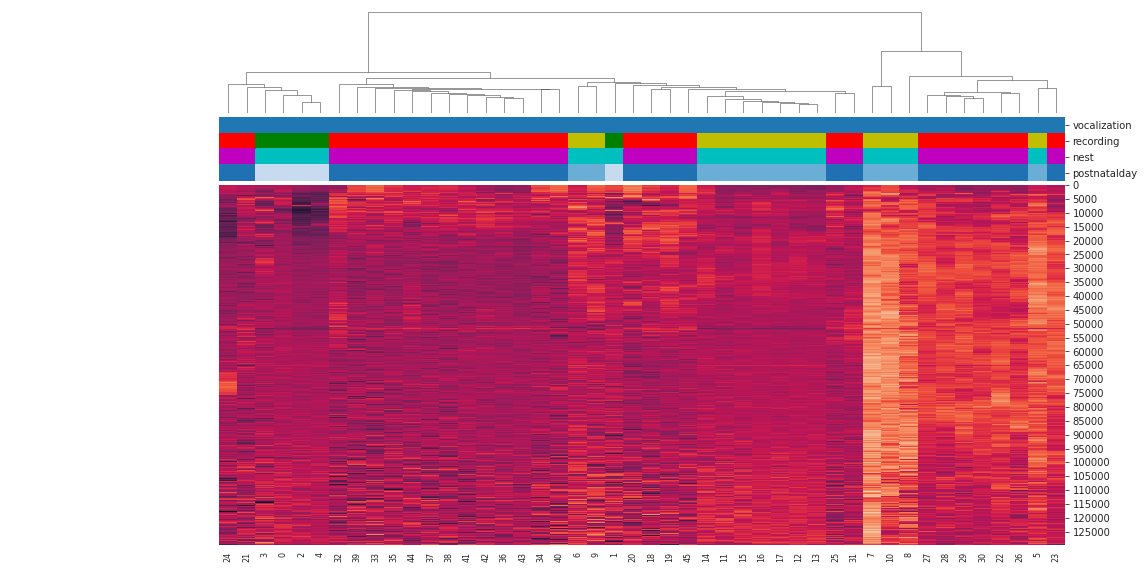

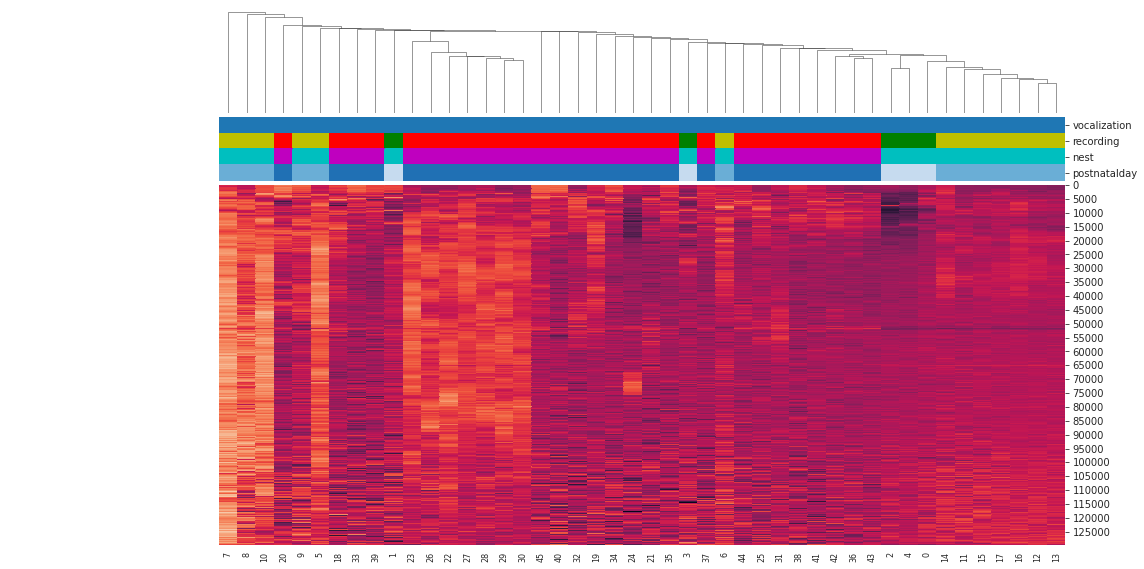

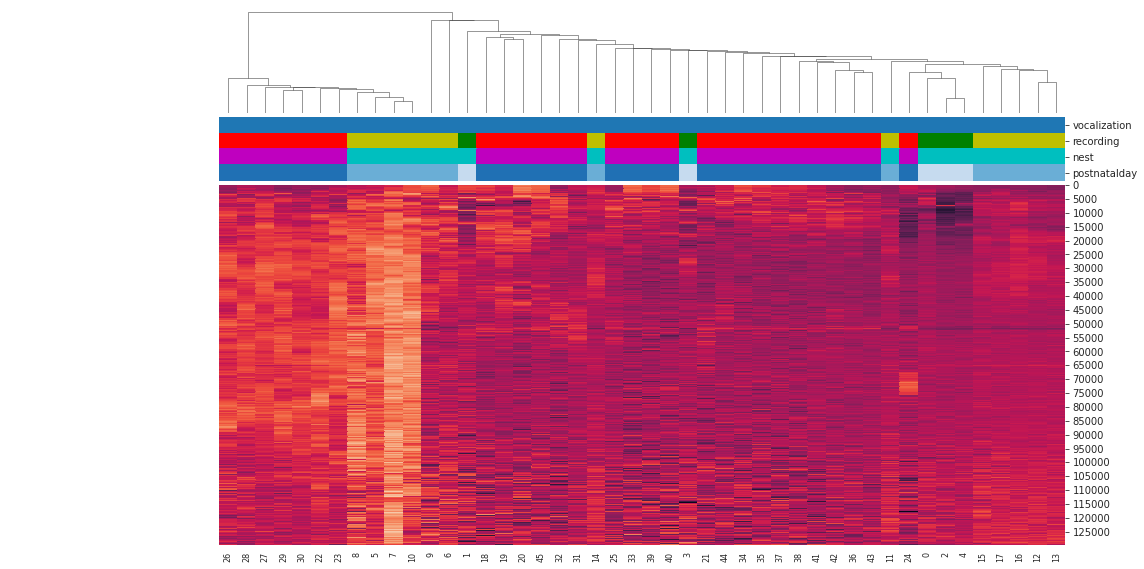

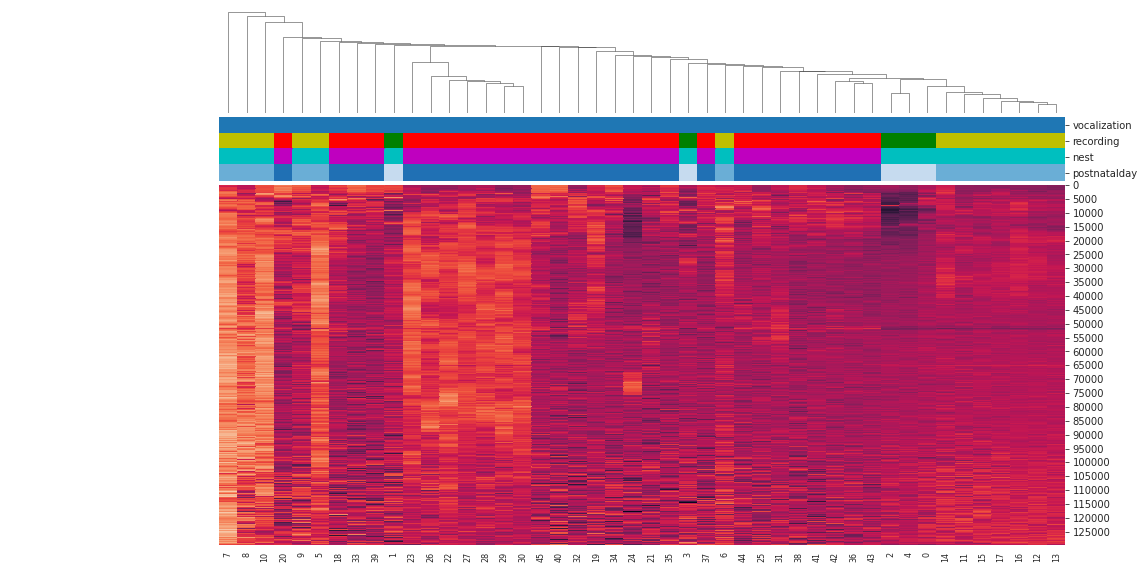

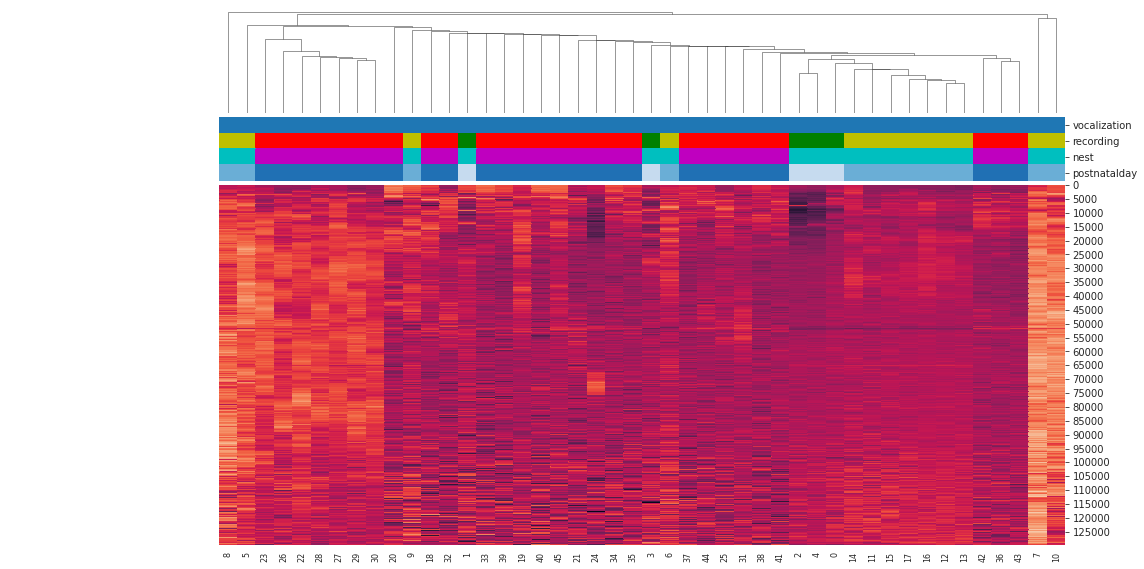

In [30]:
AFFINITIES = ["euclidean", "cosine",  "sqeuclidean", "cityblock"]
LINKAGES = ["average", "complete", "single"]  # ["ward", 

FEATS = ['mean_stft']
#FEATS = ['mean_mel']
#FEATS = ['max_mfcc', 'mean_mfcc', 'mean_mel', 'max_mel', 'mean_stft', 'max_stft']

for feat in FEATS:
    for linkage in LINKAGES:
        for metric in AFFINITIES:
    
            figtitle = f"{feat}-{linkage}-{metric}-clustermap-DEV-{VOCALIZATION}"
            print(figtitle)
            
            g = hcluster(feats[feat].T, linkage, metric, colors, feat)
            g.savefig(os.path.join(RESULTS_FOLDER, f"{figtitle}.png"))
            #cluster_index = xlabels[g.dendrogram_col.reordered_ind]